In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,)
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Input, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [33]:
def add_noise(sequence, noise_std=0.01):
    noise = np.random.normal(0, noise_std, sequence.shape)
    return sequence + noise

In [34]:
def scale_sequence(sequence, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return sequence * scale

In [35]:
def flip_pose_landmarks(landmarks):
    """Flip pose landmarks horizontally to simulate the opposite side view."""
    
    flipped_landmarks = np.copy(landmarks)
    
    # Mirror x-coordinates
    flipped_landmarks[:, 0] = 1 - flipped_landmarks[:, 0]  # Assuming x is normalized [0,1]

    # Swap left and right body parts
    left_right_pairs = [
        (11, 12), (13, 14), (15, 16),  # Shoulders, elbows, wrists
        (23, 24), (25, 26), (27, 28)   # Hips, knees, ankles
    ]
    
    for left, right in left_right_pairs:
        flipped_landmarks[[left, right]] = flipped_landmarks[[right, left]]

    return flipped_landmarks


In [36]:
metadata_csv = "metadata_file.csv"
metadata = pd.read_csv(metadata_csv)

X = []
y = []

for _, row in metadata.iterrows():
    landmarks = np.load(row["npy_file"])
    landmarks = pad_sequences([landmarks], maxlen=30, dtype='float32', padding='post', truncating='post')[0]
    X.append(landmarks)
    
    label = 1 if row["label"] == "Good" else 0
    y.append(label)    

In [37]:
X = np.array(X) # (num_reps, target_frames, num_features)
y = np.array(y) # (num_reps)

print(X.shape)
print(y.shape)

(778, 30, 132)
(778,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (561, 30, 132)
Validation data shape: (100, 30, 132)
Test data shape: (117, 30, 132)


In [39]:
# Augment training data
X_augmented = []
y_augmented = []

for i, sequence in enumerate(X_train):
    # Original sequence
    X_augmented.append(sequence)
    y_augmented.append(y_train[i])

    # Augmented sequences
    X_augmented.append(add_noise(sequence))
    y_augmented.append(y_train[i])

    X_augmented.append(scale_sequence(sequence))
    y_augmented.append(y_train[i])
    
    X_augmented.append(flip_pose_landmarks(sequence))
    y_augmented.append(y_train[i])

# Convert to NumPy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Augmented training data shape: {X_augmented.shape}")
print(f"Augmented labels shape: {y_augmented.shape}")

Augmented training data shape: (2244, 30, 132)
Augmented labels shape: (2244,)


In [40]:
# model = Sequential([
#     Input(shape=(X_augmented.shape[1], X_augmented.shape[2])), # Input shape: (sequence_lenght, features_num)
    
#     Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", kernel_regularizer=l2(0.001)),
#     LayerNormalization(),
#     MaxPooling1D(pool_size=2),
    
#     Conv1D(filters=128, kernel_size=3, activation="relu", padding="same", kernel_regularizer=l2(0.001)),
#     LayerNormalization(),
#     MaxPooling1D(pool_size=2),
    
#     Bidirectional(GRU(units=64, return_sequences=False)),
#     LayerNormalization(),
#     Dropout(0.3),
    
#     Dense(units=32, activation="relu"),
#     LayerNormalization(),
#     Dropout(0.2),
#     Dense(units=16, activation="relu"),
#     Dropout(0.2),
#     Dense(units=1, activation="sigmoid")
# ])

model = Sequential([
    Input(shape=(X_augmented.shape[1], X_augmented.shape[2])), # Input shape: (sequence_lenght, features_num)
    
    Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", kernel_regularizer=l2(0.001)),
    LayerNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=128, kernel_size=3, activation="relu", padding="same", kernel_regularizer=l2(0.001)),
    LayerNormalization(),
    MaxPooling1D(pool_size=2),
    
    Bidirectional(GRU(units=128, return_sequences=False, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))),
    LayerNormalization(),
    Dropout(0.3),
    
    Dense(units=64, activation="relu", kernel_regularizer=l2(0.001)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 30, 64)         │        25,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 15, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,793 (1.01 MB)

 Trainable params: 265,793 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
]

In [42]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 100,
    batch_size = 32,
    callbacks = callbacks
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.4738 - loss: 1.7811 - val_accuracy: 0.6000 - val_loss: 1.5830 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5824 - loss: 1.6253 - val_accuracy: 0.6700 - val_loss: 1.5572 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5218 - loss: 1.6403 - val_accuracy: 0.6800 - val_loss: 1.5484 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6361 - loss: 1.5413 - val_accuracy: 0.6500 - val_loss: 1.5324 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6102 - loss: 1.5499 - val_accuracy: 0.6700 - val_loss: 1.4801 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6800 - loss: 1.4707 - val_accuracy: 0.6600 - val_loss: 1.4663 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 

In [43]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9561 - loss: 0.8367
Test Accuracy: 0.97


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9561 - loss: 0.8367
Test Loss: 0.7858561873435974
Test Accuracy: 0.9658119678497314


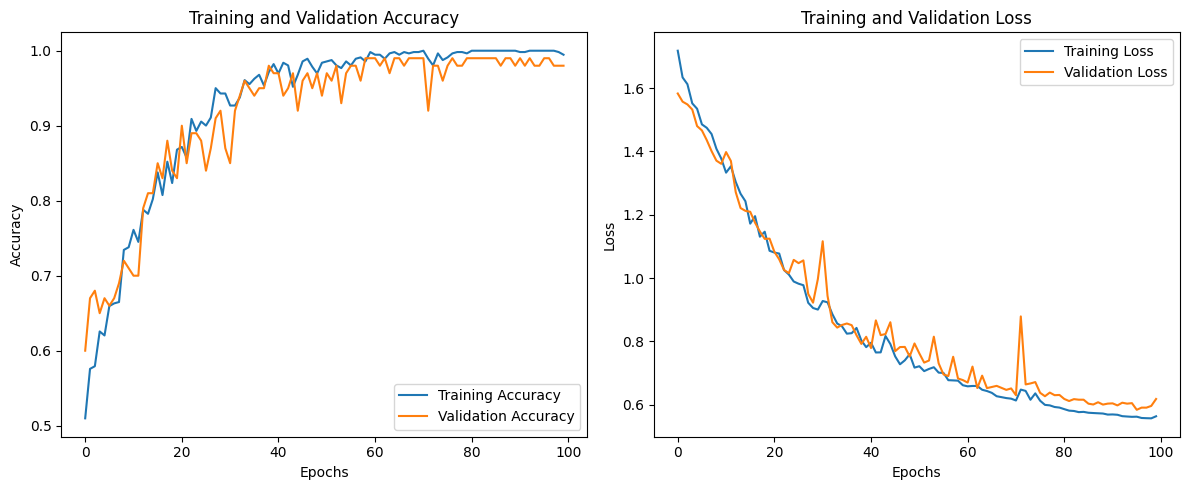

In [44]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training history (optional)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.6).astype(int)
y_true = y_test

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step


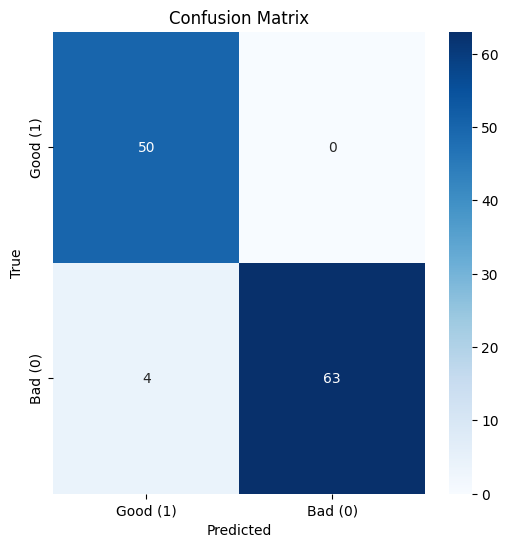

In [46]:
# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_true, y_pred_classes)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Good (1)", "Bad (0)"], yticklabels=["Good (1)", "Bad (0)"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [47]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9658


In [48]:
precision = precision_score(y_true, y_pred_classes)
print(f"Precision: {precision:.4f}")

Precision: 1.0000


In [49]:
recall = recall_score(y_true, y_pred_classes)
print(f"Recall: {recall:.4f}")

Recall: 0.9403


In [50]:
f1 = f1_score(y_true, y_pred_classes)
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.9692


In [52]:
model.save("squat_form_classifier.h5")